In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


sdata = pd.read_csv('data/stars/pulsar_stars.csv')

In [ ]:
sdata.head()

In [ ]:
Обучение через рандом форест (прочитать про)
не удалять негативные результаты
для нормализованных данных провести сравнение до нормализации и после
попробовтаь использовать кросс валидацию для улучшения результата
попробовтаь undersampling 
написать саммари
шум? метод понижения размерностей
удалить из трейна шум

*убрать низко корреляционные фичи и добавить новые с большим коэффицентом кореляции, допустим заменить 0,3 на 0,5

In [ ]:
Для презентации:
дата сет
методы для нормализации
модели обучения
сравнение результатов
почему такой результат

In [ ]:
sdata.columns

Changing columns names

In [2]:
sdata.rename(columns={' Mean of the integrated profile':'mean_ip',
                      ' Standard deviation of the integrated profile':'std_ip',
                      ' Excess kurtosis of the integrated profile':'excess_ip', 
                      ' Skewness of the integrated profile':'skew_ip',
                      ' Mean of the DM-SNR curve':'mean_dm-snr',
                      ' Standard deviation of the DM-SNR curve':'std_dm-snr',
                      ' Excess kurtosis of the DM-SNR curve':'excess_dm-snr',
                      ' Skewness of the DM-SNR curve':'skew_dm-snr'},
                 inplace=True)

In [ ]:
sdata.info()

According to info we have data in all features for all stars

In [ ]:
sdata.describe()

In [ ]:
sdata['target_class'].mean()

In data set there are 9,1% pulsar stars

In [ ]:
sns.pairplot(sdata, hue="target_class")

на основании этого графика можно сделать вывод что линейную регрессию использовать не получится, т.к. данные имеют большое пересечение

На графике прослеживается шум, одна или несколько (т.к. видны на нескольких графиках) из звезд явно выбивается общей группы

In [ ]:
stars=sdata.loc[sdata['target_class'] == 1]
sorted = stars.sort_values(by=['skew_dm-snr'], ascending=False)
top10 = sorted['skew_dm-snr'][:10]
top10

In [ ]:
sorted = stars.sort_values(by=['excess_dm-snr'], ascending=False)
top10 = sorted['excess_dm-snr'][:10]
top10

Одна из звезд явно выбивается из общей группы. Извлечем её из общего списка чтобы потом добавить в тест выборку

In [ ]:
extraStar = sdata.loc[11822]

In [3]:
sdata.drop(11822,axis=0,inplace=True)

In [ ]:
correlation = sdata.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("magma"),
            linewidth=2,edgecolor="k",ax=ax)

Following heatmap shows correlation between features.

There is a high positive correlation between following features:
    Excess kurtosis of the integrated profile - Skewness of the integrated profile (0.95)
    Mean of the DM-SNR curve - Standard deviation of the DM-SNR curve(0.80)
    Excess kurtosis of the DM-SNR curve - Skewness of the DM-SNR curve (0.92)
There is a high negative correlation between following features:
    Mean of the integrated profile - Excess kurtosis of the integrated profile (-0.87)
    Mean of the integrated profile - Skewness of the integrated profile (-0.74)
    Standard deviation of the DM-SNR curve - Excess kurtosis of the DM-SNR curve (-0.81)

There is a low correlation between following features:
    Standard deviation of the integrated profile - all columns with DM-SNR curve
    Skewness of the DM-SNR curve - Standard deviation of the integrated profile, Excess kurtosis of the integrated profile and Skewness of the integrated profile 

In [ ]:
Попробуем добавить новые параметры и посмотреть как они будут коррелировать с типом звезды

In [ ]:
sdata1=sdata.copy()
sdata1['x11']=sdata['mean_ip']/sdata['std_ip'] -
sdata1['x12']=sdata['mean_ip']/sdata['excess_ip']
sdata1['x13']=sdata['mean_ip']/sdata['skew_ip']
sdata1['x14']=sdata['mean_ip']/sdata['mean_dm-snr']
sdata1['x15']=sdata['mean_ip']/sdata['std_dm-snr']
sdata1['x16']=sdata['mean_ip']/sdata['excess_dm-snr']
sdata1['x17']=sdata['mean_ip']/sdata['skew_dm-snr']

sdata1['x21']=sdata['std_ip']/sdata['mean_ip'] -
sdata1['x22']=sdata['std_ip']/sdata['excess_ip']
sdata1['x23']=sdata['std_ip']/sdata['skew_ip']
sdata1['x24']=sdata['std_ip']/sdata['mean_dm-snr']
sdata1['x25']=sdata['std_ip']/sdata['std_dm-snr']
sdata1['x26']=sdata['std_ip']/sdata['excess_dm-snr']
sdata1['x27']=sdata['std_ip']/sdata['skew_dm-snr']

sdata1['x31']=sdata['excess_ip']/sdata['std_ip'] -
sdata1['x32']=sdata['excess_ip']/sdata['mean_ip']
sdata1['x33']=sdata['excess_ip']/sdata['skew_ip']
sdata1['x34']=sdata['excess_ip']/sdata['mean_dm-snr']
sdata1['x35']=sdata['excess_ip']/sdata['std_dm-snr']
sdata1['x36']=sdata['excess_ip']/sdata['excess_dm-snr']
sdata1['x37']=sdata['excess_ip']/sdata['skew_dm-snr']

sdata1['x41']=sdata['skew_ip']/sdata['std_ip'] -
sdata1['x42']=sdata['skew_ip']/sdata['excess_ip']
sdata1['x43']=sdata['skew_ip']/sdata['mean_ip']
sdata1['x44']=sdata['skew_ip']/sdata['mean_dm-snr']
sdata1['x45']=sdata['skew_ip']/sdata['std_dm-snr'] -
sdata1['x46']=sdata['skew_ip']/sdata['excess_dm-snr']
sdata1['x47']=sdata['skew_ip']/sdata['skew_dm-snr']

sdata1['x51']=sdata['mean_dm-snr']/sdata['std_ip']
sdata1['x52']=sdata['mean_dm-snr']/sdata['excess_ip']
sdata1['x53']=sdata['mean_dm-snr']/sdata['skew_ip']
sdata1['x54']=sdata['mean_dm-snr']/sdata['mean_ip']
sdata1['x55']=sdata['mean_dm-snr']/sdata['std_dm-snr']
sdata1['x56']=sdata['mean_dm-snr']/sdata['excess_dm-snr']
sdata1['x57']=sdata['mean_dm-snr']/sdata['skew_dm-snr']

sdata1['x61']=sdata['std_dm-snr']/sdata['std_ip'] -
sdata1['x62']=sdata['std_dm-snr']/sdata['excess_ip']
sdata1['x63']=sdata['std_dm-snr']/sdata['skew_ip']
sdata1['x64']=sdata['std_dm-snr']/sdata['mean_dm-snr']
sdata1['x65']=sdata['std_dm-snr']/sdata['mean_ip'] -
sdata1['x66']=sdata['std_dm-snr']/sdata['excess_dm-snr']
sdata1['x67']=sdata['std_dm-snr']/sdata['skew_dm-snr']

sdata1['x71']=sdata['excess_dm-snr']/sdata['std_ip']
sdata1['x72']=sdata['excess_dm-snr']/sdata['excess_ip']
sdata1['x73']=sdata['excess_dm-snr']/sdata['skew_ip']
sdata1['x74']=sdata['excess_dm-snr']/sdata['mean_dm-snr']
sdata1['x75']=sdata['excess_dm-snr']/sdata['std_dm-snr']
sdata1['x76']=sdata['excess_dm-snr']/sdata['mean_ip']
sdata1['x77']=sdata['excess_dm-snr']/sdata['skew_dm-snr']

In [ ]:
corr_matrix = sdata1.corr()['target_class'].sort_values(ascending=False)

In [ ]:
Добавим в датасет те, которые имеют наибольший коэф. корреляции

In [4]:
sdata2=sdata.copy()
sdata2['x11']=sdata['mean_ip']/sdata['std_ip']
sdata2['x21']=sdata['std_ip']/sdata['mean_ip']
sdata2['x31']=sdata['excess_ip']/sdata['std_ip']
sdata2['x32']=sdata['excess_ip']/sdata['mean_ip']
sdata2['x41']=sdata['skew_ip']/sdata['std_ip']
sdata2['x45']=sdata['skew_ip']/sdata['std_dm-snr']
sdata2['x61']=sdata['std_dm-snr']/sdata['std_ip']
sdata2['x65']=sdata['std_dm-snr']/sdata['mean_ip']


In [ ]:
sdata.head()

In [ ]:
correlation2 = sdata2.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation2,annot=True,
            cmap=sns.color_palette("magma"),
            linewidth=2,edgecolor="k",ax=ax)

In [ ]:
Уберем из датасета параметры с низкой корреляций и параметры которые тесно связаны с другими параметрами

In [5]:

sdata2.drop(["std_ip"],axis=1,inplace=True)
sdata2.drop(["skew_dm-snr"],axis=1,inplace=True)
sdata2.drop(["x21"],axis=1,inplace=True)
sdata2.drop(["x11"],axis=1,inplace=True)
sdata2.drop(["x61"],axis=1,inplace=True)

In [ ]:
Графики распределения параметров в датасете (в общем по датасету и разделенные по категориям)

In [ ]:
f, axes = plt.subplots(2,4, figsize=(20, 12))
sns.distplot( sdata["mean_ip"], ax=axes[0,0])
sns.distplot( sdata["std_ip"], ax=axes[0,1])
sns.distplot( sdata["excess_ip"], ax=axes[0,2])
sns.distplot( sdata["skew_ip"], ax=axes[0,3])
sns.distplot( sdata["mean_dm-snr"], ax=axes[1,0])
sns.distplot( sdata["std_dm-snr"], ax=axes[1,1])
sns.distplot( sdata["excess_dm-snr"], ax=axes[1,2])
sns.distplot( sdata["skew_dm-snr"], ax=axes[1,3])

In [ ]:
filterStar = sdata["target_class"]==1
filterNotStar = sdata["target_class"]==0
stardata=sdata.loc[sdata['target_class'] == 1]
notStardata=sdata.loc[sdata['target_class'] == 0]
f, axes = plt.subplots(4,4, figsize=(20, 12))
sns.distplot( stardata["mean_ip"], ax=axes[0,0], color="tab:red")
sns.distplot( stardata["std_ip"], ax=axes[0,1], color="tab:red")
sns.distplot( stardata["excess_ip"], ax=axes[0,2], color="tab:red")
sns.distplot( stardata["skew_ip"], ax=axes[0,3], color="tab:red")
sns.distplot( stardata["mean_dm-snr"], ax=axes[1,0], color="tab:red")
sns.distplot( stardata["std_dm-snr"], ax=axes[1,1], color="tab:red")
sns.distplot( stardata["excess_dm-snr"], ax=axes[1,2], color="tab:red")
sns.distplot( stardata["skew_dm-snr"], ax=axes[1,3], color="tab:red")

sns.distplot( notStardata["mean_ip"], ax=axes[2,0])
sns.distplot( notStardata["std_ip"], ax=axes[2,1])
sns.distplot( notStardata["excess_ip"], ax=axes[2,2])
sns.distplot( notStardata["skew_ip"], ax=axes[2,3])
sns.distplot( notStardata["mean_dm-snr"], ax=axes[3,0])
sns.distplot( notStardata["std_dm-snr"], ax=axes[3,1])
sns.distplot( notStardata["excess_dm-snr"], ax=axes[3,2])
sns.distplot( notStardata["skew_dm-snr"], ax=axes[3,3])

Prediction witouth any data adjustment

In [6]:
y = sdata["target_class"].values
sdata.drop(["target_class"],axis=1,inplace=True)
features = sdata.values
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3, random_state=123, stratify=y)


 accuracy_score : 0.9813780260707635


Text(0.5, 1, 'CONFUSION MATRIX')

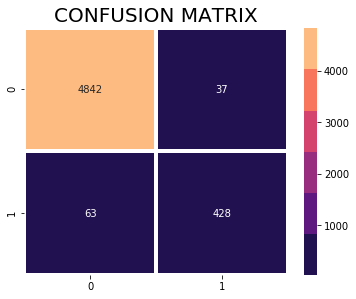

In [7]:
rfc_model = RandomForestClassifier(n_estimators=100,random_state=42,max_leaf_nodes=200,criterion="gini")
rfc_model.fit(X_train,y_train)
predict_rfc = rfc_model.predict(X_test)
rfc_score = rfc_model.score(X_test,y_test)
print ("\n accuracy_score :",rfc_score)

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, predict_rfc),annot=True,fmt = "d",linecolor="w", cmap=sns.color_palette("magma"),linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

GradientBoosting


 accuracy_score : 0.978584729981378


Text(0.5, 1, 'CONFUSION MATRIX')

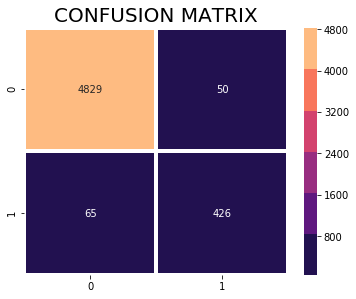

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
gbc_prediction = gbc.predict(X_test)
gbc_score = gbc.score(X_test,y_test)
print ("\n accuracy_score :",gbc_score)

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, gbc_prediction),annot=True,fmt = "d",linecolor="w", cmap=sns.color_palette("magma"),linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)


In [ ]:
Gradient boosting для не обработанных данных дал результат чуть хуже, кол-во определенных звезд уменьшилось и 
возросло число false-negative и false-positive

Create additional train set with data after manipulation

In [9]:
y = sdata2["target_class"].values
sdata2.drop(["target_class"],axis=1,inplace=True)


features_reduced = sdata2.values
Xr_train, Xr_test, yr_train, yr_test = train_test_split(features_reduced, y, test_size = 0.3, random_state=123, stratify=y)


 accuracy_score : 0.9813780260707635


Text(0.5, 1, 'CONFUSION MATRIX')

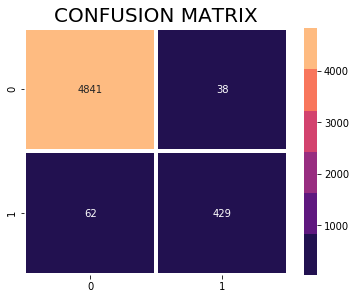

In [10]:
rfc_model = RandomForestClassifier(n_estimators=100,random_state=42,max_leaf_nodes=200,criterion="gini")
rfc_model.fit(Xr_train,yr_train)
predict_rfc_red = rfc_model.predict(Xr_test)
rfc_score_red = rfc_model.score(Xr_test,yr_test)
print ("\n accuracy_score :",rfc_score_red)

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(yr_test, predict_rfc_red),annot=True,fmt = "d",linecolor="w", cmap=sns.color_palette("magma"),linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

После добавления новых фич результат стал незначительно лучше


 accuracy_score : 0.9793296089385475


Text(0.5, 1, 'CONFUSION MATRIX')

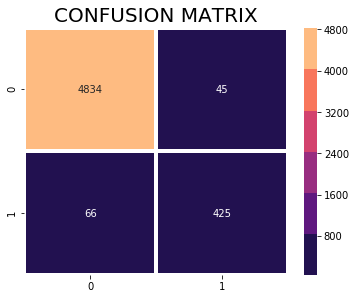

In [11]:
gbc = GradientBoostingClassifier()
gbc.fit(Xr_train,yr_train)
gbc_prediction_red = gbc.predict(Xr_test)
gbc_score = gbc.score(Xr_test,yr_test)
print ("\n accuracy_score :",gbc_score)

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(yr_test, gbc_prediction_red),annot=True,fmt = "d",linecolor="w", cmap=sns.color_palette("magma"),linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

Изменение кол-ва фич положительно сказалось на градиентБустинге в сторону уменьшения числа false-positive

Prediction with data normalization. Try to normalize data with MinMax Scaler (Standard scaler hasn't give any result)


 accuracy_score : 0.9808193668528864


Text(0.5, 1, 'CONFUSION MATRIX')

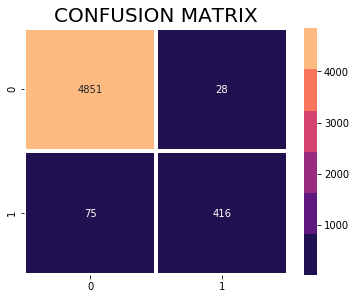

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
Xs_train = scaler.fit_transform(Xr_train)
Xs_test = scaler.fit_transform(Xr_test)


rfc_model = RandomForestClassifier(n_estimators=500,random_state=42,max_leaf_nodes=500,criterion="gini")
rfc_model.fit(Xs_train,yr_train)
predict_rfc = rfc_model.predict(Xs_test)
rfc_score = rfc_model.score(Xs_test,yr_test)
print ("\n accuracy_score :",rfc_score)

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(yr_test, predict_rfc),annot=True,fmt = "d",linecolor="w", cmap=sns.color_palette("magma"),linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)


 accuracy_score : 0.9649906890130354


Text(0.5, 1, 'CONFUSION MATRIX')

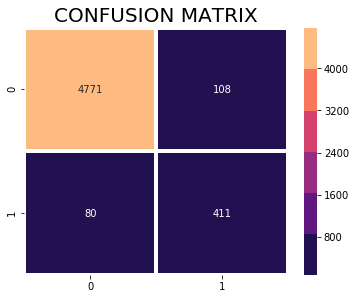

In [13]:
gbc = GradientBoostingClassifier()
gbc.fit(Xs_train,y_train)
gbc_prediction = gbc.predict(Xs_test)
gbc_score = gbc.score(Xs_test,yr_test)
print ("\n accuracy_score :",gbc_score)

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(yr_test, gbc_prediction),annot=True,fmt = "d",linecolor="w", cmap=sns.color_palette("magma"),linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)




 accuracy_score : 0.9783985102420857


Text(0.5, 1, 'CONFUSION MATRIX')

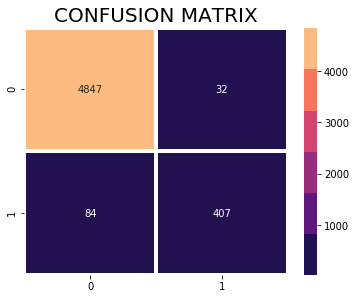

In [14]:
from sklearn.ensemble import AdaBoostClassifier
ada_normS_model = AdaBoostClassifier()
ada_normS_model.fit(Xs_train,y_train)
yada_normS_head_rfc = ada_normS_model.predict(Xs_test)
ada_norms_score = ada_normS_model.score(Xs_test,yr_test)

print ("\n accuracy_score :",ada_norms_score)

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(yr_test, yada_normS_head_rfc),annot=True,fmt = "d",linecolor="w", cmap=sns.color_palette("magma"),linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

In [ ]:
Min-max scaling значительно ухудшил результат для всех типов обучения, количество успешно определенных звезд значительно снизилось